In [1]:
DEBUG = False
CONFIG_FILE = '/datascope/subaru/data/targeting/dSph/bootes_ENG/netflow/bootes_ENG_003/ga-netflow_20250122053207.config'
OUTPUT_PATH = '/datascope/subaru/data/targeting/dSph/bootes_ENG/netflow/bootes_ENG_003'

# Plot the design files

In [2]:
import os, sys, re
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rc('font', size=6) #controls default text size

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
if DEBUG and 'debug' not in globals():
    import debugpy
    debugpy.listen(('0.0.0.0', int(os.environ['PFS_TARGETING_DEBUGPORT'])))
    debug = True

# Imports

In [6]:
import pfs.utils
from pfs.datamodel import PfsDesign, FiberStatus, TargetType

from pfs.ga.targeting.scripts.netflow.notebooks.notebooks import *
from pfs.ga.targeting.instrument import *


# Load the netflow config file

In [7]:
# Load the configuration
config = load_netflow_config(CONFIG_FILE)

2025-01-22T15:02:34.073 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-22T15:02:34.106 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-22T15:02:34.135 20 cobraCoach cc connecting to fpga....
2025-01-22T15:02:34.260 30 butler     newRun: /tmp/cobra_coach/20250122_094


# Plot the design files

In [8]:
# Create the PFI instrument. This will load the instrument calibration data.
pfi = SubaruPFI(instrument_options=config.instrument_options)

2025-01-22T15:02:39.840 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-22T15:02:39.872 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-22T15:02:39.879 20 cobraCoach cc connecting to fpga....
2025-01-22T15:02:39.881 30 butler     newRun: /tmp/cobra_coach/20250122_095


In [9]:
# Find and load the design files in the output directory
designs = {}
design_files = glob(os.path.join(OUTPUT_PATH, 'pfsDesign*.fits'))
for fn in design_files:
    pfsDesignId = int(re.search(r'0x[0-9a-f]+', fn).group(0), 16)
    design = PfsDesign.read(pfsDesignId, dirName=os.path.dirname(fn))
    designs[pfsDesignId] = design
    print(f'Loaded design 0x{pfsDesignId:016x}')

Loaded design 0x3fdeaed22f0b2925


In [10]:
# Verify that there are no duplicate fiberIds
for pfsDesignId, design in designs.items():
    counts = np.bincount(design.fiberId)
    print(f'0x{pfsDesignId:016x}', np.where(counts > 1))

0x3fdeaed22f0b2925 (array([], dtype=int64),)


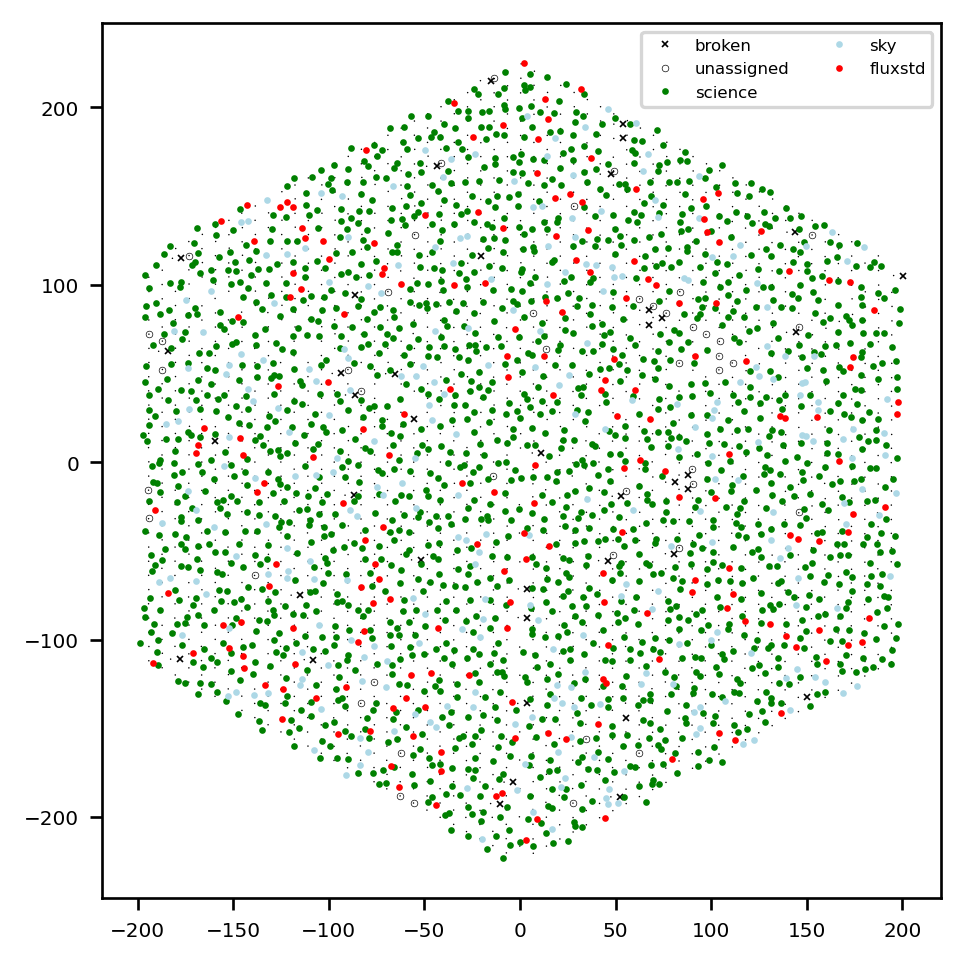

In [11]:
for pfsDesignId, design in designs.items():
        f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=240)

        # Cobra centers
        ax.scatter(pfi.bench.cobras.centers.real, pfi.bench.cobras.centers.imag, 
                   s=0.2, color='black', edgecolors='none')

        # Broken cobras or fibers
        mask = (design.fiberStatus != FiberStatus.GOOD)
        ax.plot(design.pfiNominal[mask][..., 0], design.pfiNominal[mask][..., 1], 'x', ms=2, label='broken',
                color='black', markeredgewidth=0.5)

        # Unassigned good cobras
        mask = (design.fiberStatus == FiberStatus.GOOD) & (design.targetType == TargetType.UNASSIGNED)
        ax.plot(design.pfiNominal[mask][..., 0], design.pfiNominal[mask][..., 1], 'o', ms=2, label='unassigned',
                markerfacecolor='none', markeredgecolor='black', markeredgewidth=0.2)

        # Good science targets
        mask = (design.fiberStatus == FiberStatus.GOOD) & (design.targetType == TargetType.SCIENCE)
        ax.plot(design.pfiNominal[mask][..., 0], design.pfiNominal[mask][..., 1], 'o', ms=1, label='science', color='green')

        # Good sky fibers
        mask = (design.fiberStatus == FiberStatus.GOOD) & (design.targetType == TargetType.SKY)
        ax.plot(design.pfiNominal[mask][..., 0], design.pfiNominal[mask][..., 1], 'o', ms=1, label='sky', color='lightblue')

        # Good flux standards
        mask = (design.fiberStatus == FiberStatus.GOOD) & (design.targetType == TargetType.FLUXSTD)
        ax.plot(design.pfiNominal[mask][..., 0], design.pfiNominal[mask][..., 1], 'o', ms=1, label='fluxstd', color='red')

        # Make legend horizontal
        ax.legend(loc='upper right', ncol=2, fontsize='small')
        f.tight_layout()